# Importing Libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import models, layers
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout , Bidirectional

import pickle

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

2025-08-12 11:15:33.504733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754997333.682345      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754997333.740446      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


True

# Read Data

In [5]:
cols_names = ["Index", "Entity", "Sentiments", "Text"]

train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header=None, names=cols_names)
valid = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header=None, names=cols_names)
df = pd.concat([train , valid] , ignore_index=True )

In [6]:
df.head()

,Index,Entity,Sentiments,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Data Cleaning

In [7]:
df.shape

(75682, 4)

In [8]:
df.isna().sum()

Index           0
Entity          0
Sentiments      0
Text          686
dtype: int64

In [9]:
# drop nan values
df.dropna(inplace=True)

In [10]:
df.duplicated().sum()

2857

In [11]:
# drop duplicated values
df.drop_duplicates(inplace=True)

In [12]:
df.shape

(72139, 4)

In [13]:
df.sample(5)

,Index,Entity,Sentiments,Text
14124,2822,Dota2,Positive,"Ranked Dota 2, new patch, and music !giveaway ..."
2530,1641,CallOfDutyBlackopsColdWar,Irrelevant,Proud of this unfortunate headline.
37424,5217,Hearthstone,Negative,@ PlayHearthstone 1 mana hero power that deals...
56556,11305,TomClancysRainbowSix,Negative,@Rainbow6Game can you fucks lower the ranked r...
9318,12802,Xbox(Xseries),Irrelevant,I Tried To Preorder An Xbox Series S - That We...


# Data Preprocessing

In [14]:
stop_words_set = set(stopwords.words('english'))

def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'https?://\S+|www\.\S+', ' ', sentence)
    sentence = re.sub(r'[^\x00-\x7F]', ' ', sentence)
    sentence = re.sub(r'\d+', ' ', sentence)
    sentence = re.sub(r'[^a-z\s]', ' ', sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence).strip()
    contractions_map = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    for c_pattern, c_replacement in contractions_map.items():
        sentence = re.sub(c_pattern, c_replacement, sentence)
    sentence = re.sub(r'\bunk\b', '', sentence)
    words = [word for word in sentence.split() if word not in stop_words_set]
    sentence = ' '.join(words)
    return sentence

df['Text'] = df['Text'].apply(preprocess_text)


In [15]:
df.head()

,Index,Entity,Sentiments,Text
0,2401,Borderlands,Positive,im getting borderlands murder
1,2401,Borderlands,Positive,coming borders kill
2,2401,Borderlands,Positive,im getting borderlands kill
3,2401,Borderlands,Positive,im coming borderlands murder
4,2401,Borderlands,Positive,im getting borderlands murder


In [16]:
df['Sentiments'].value_counts()

Sentiments
Negative      21790
Positive      19846
Neutral       17879
Irrelevant    12624
Name: count, dtype: int64

# Encoding 

In [17]:
df['Sentiments'] = df['Sentiments'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [18]:
x = df['Text']
y = df['Sentiments']

# split data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Tokenizer Model

In [20]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 5️⃣ Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# 6️⃣ Padding (define maxlen first)
maxlen = 100
X_train_pad = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

In [21]:
# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# LSTM Model

### Build Model

In [22]:
vocab_size = 10000  
max_sequence_length = 100  

model = models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1754997402.293015      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754997402.293665      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [25]:
history = model.fit(
    X_train_pad, 
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15,
    batch_size=64,
    verbose=1
)


Epoch 1/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9459 - loss: 0.1268 - val_accuracy: 0.8612 - val_loss: 0.5337
Epoch 2/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9504 - loss: 0.1178 - val_accuracy: 0.8653 - val_loss: 0.5433
Epoch 3/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9510 - loss: 0.1116 - val_accuracy: 0.8651 - val_loss: 0.5609
Epoch 4/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9542 - loss: 0.1053 - val_accuracy: 0.8657 - val_loss: 0.5665
Epoch 5/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9581 - loss: 0.0964 - val_accuracy: 0.8633 - val_loss: 0.5570
Epoch 6/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9575 - loss: 0.0983 - val_accuracy: 0.8687 - val_loss: 0.5817
Epoch 7/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9605 - loss: 0.0894 - val_accuracy: 0.8611 - val_loss: 0.6311
Epoch 8/15
902/902 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9618 - loss: 0.0835 - 

# Model Evaluation

In [28]:
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8708 - loss: 0.6564
Test Loss: 0.6472
Test Accuracy: 87.35%


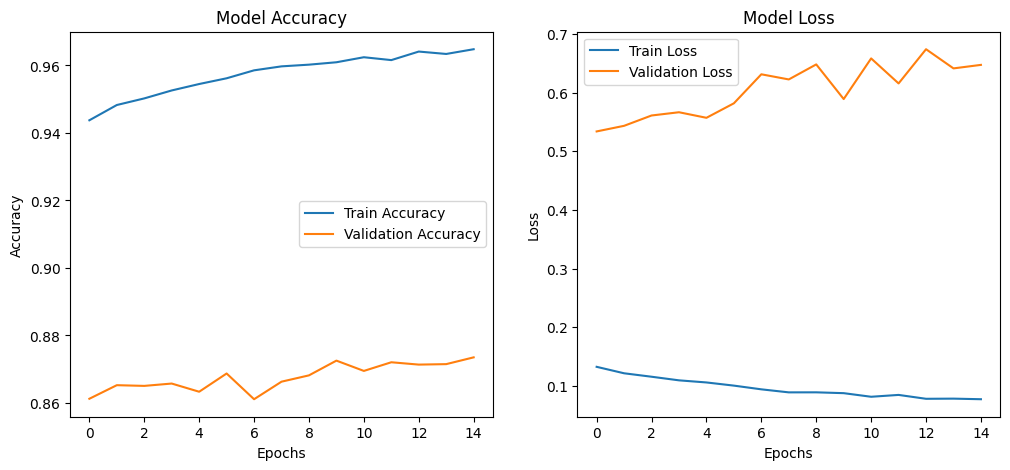

In [29]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Save Model

In [27]:
model.save('lstm_model.h5')